# Введение
В нашем распоряжении файл с данными об аукционах автомобилей США и Канады. Построим модель обучения которая на осове этих данных будет предсказывать цену БУ авто на рынке.

## Данные 
- Date: Год выпуска автомобиля.
- Make: Марка автомобиля.
- Model: Модель автомобиля определенной марки.
- Trim: Модификации автомобиля.
- Body: Тип кузова транспортного средства относится к форме и модели конкретной марки автомобиля.
- Transmission: Тип коробки передач.
- VIN: Идентификационный номер транспортного средства.
- State: Штат регистрации автомобиля
- Condition: Состояние автомобилей на момент аукциона.
- Odometer: Пробег - расстояние, пройденное автомобилем с момента выпуска.
- Color: Цвет кузова автомобиля.
- Interior: Цвет салона автомобиля.
- Seller: Продавец автомобиля, автосалоны.
- sellingprice: цена, по которой автомобиль был продан на аукционе.
- saledate: Дата продажи автомобиля.

В качестве метрики качества будем использовать MAPE

В ходе работы в пройдем основные этапы исследования:
-    загрузка и ознакомление с данными,
-    предварительная обработка,
-    полноценный разведочный анализ,
-    разработка новых синтетических признаков,
-    проверка на мультиколлинеарность,
-    отбор финального набора обучающих признаков,
-    выбор и обучение моделей,
-    итоговая оценка качества предсказания лучшей модели,
-    анализ важности ее признаков.

# Предобработка и анализ

In [1]:
!pip install scikit-learn==1.1.3
!pip install phik
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
import phik
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.compose import make_column_transformer
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("train.csv")
print(df.info())
print(df.describe())
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB
None
                year      condition       odometer   sellingprice
count 

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)


Мы видим, что есть некоторые пропуски в значениях, с другой стороны все колонки названы корректо, их значения в удобных для анализа типах. Посмотрим где есть пропуски. Так же мы видим аномальные значения цены в 1 единицу и пробег. Нужно поработать с пропусками и выбросами и заглавными словами.

In [4]:
df.isna().sum()

year                0
make             8043
model            8123
trim             8337
body            10393
transmission    51461
vin                 0
state               0
condition        9405
odometer           69
color             586
interior          586
seller              0
sellingprice        0
saledate            0
dtype: int64

In [5]:
df['saledate'] = pd.to_datetime(df['saledate'], utc=True) # преобразуем даты в нужный вид

C:\Users\Artem\AppData\Local\Temp\ipykernel_1504\1073586907.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['saledate'] = pd.to_datetime(df['saledate'], utc=True) # преобразуем даты в нужный вид


In [6]:
df['year'].value_counts()

year
2012    80625
2013    77566
2014    64225
2011    38115
2008    24646
2007    24152
2006    21118
2010    20647
2005    16794
2009    16064
2004    13658
2003    10512
2002     7726
2015     7462
2001     5147
2000     4161
1999     2658
1998     1747
1997     1224
1996      683
1995      567
1994      319
1993      168
1992      103
1991       56
1990       38
1989       15
1988       11
1985       10
1986        8
1987        5
1984        4
1983        1
1982        1
Name: count, dtype: int64

Мы видим что все авто находятся в рамках 30 лет, что удовлетваряет требованию эксплуатации

In [7]:
df['vin'].duplicated().sum() # нет дубликатов уникальных номеров

0

In [8]:
df["make"].value_counts()

make
Ford         73708
Chevrolet    47492
Nissan       42811
Toyota       31630
Dodge        24103
             ...  
Daewoo           1
dodge tk         1
mazda tk         1
dot              1
airstream        1
Name: count, Length: 92, dtype: int64

In [9]:
df["model"].value_counts()

model
Altima           15454
F-150            11408
Fusion           10244
Camry             9996
Escape            9419
                 ...  
Civic del Sol        1
Tempo                1
Regency              1
8 Series             1
g500                 1
Name: count, Length: 959, dtype: int64

Мы видим что марка и модель отсуствуют в данных практически в одинаковом количестве. В целом марка автомобиля слишком важный параметр чтобы просто игнорировать его отсуствие. У нас доступны vin номера автомобилей. Я попробую подгрузить модели по уникальным номерам из открытых источников.

In [10]:
df_vin = df.query("model.isna()")['vin'] # создам срез по вин номерам в которых отсуствуюм модели автомобилей

In [11]:
API_URL = 'https://vpic.nhtsa.dot.gov/api/vehicles/DecodeVINValuesBatch/'

def fetch_vin_data(vin_list, dryrun=False):
    delimited_vin_list = ';'.join(vin_list)
    post_fields = { 'format': 'json', 'data': delimited_vin_list }
    if dryrun:
        print("Querying for", delimited_vin_list)
        return pd.DataFrame([])
    else:
        response = requests.post(API_URL, data=post_fields)
        return pd.DataFrame(response.json()['Results'])

numbers_per_batch = 1000
start = 8200
total = len(df_vin)

# в базе данных ограничения, придется качать по 50 штук

offset = start
error_offsets = []
while offset <= (start + total):
    try:
        filename = f"vin_cache___/{start}-{offset}-{total}-{numbers_per_batch}.csv"
        if not os.path.exists(filename):
            time.sleep(1)
            print(f"\rQuerying {offset - start} / {total- start} - batch of {numbers_per_batch} ", end='')
            current = df_vin[offset:offset+numbers_per_batch]

            result = fetch_vin_data(current)
            result.to_csv(filename, index=False)
        else:
            print(f"\rSkipping {offset - start} / {total - start} - batch of {numbers_per_batch} ", end='')
    except:
        pass
    offset = offset + numbers_per_batch

In [12]:
new_vin_dates = pd.read_csv("new_vin_dates.csv")
new_vin_dates.info() # проверяем, все получилось

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8123 entries, 0 to 8122
Columns: 150 entries, ABS to Windows
dtypes: float64(87), int64(2), object(61)
memory usage: 9.3+ MB


In [13]:
new_vin_dates['Model'].isnull().sum() # получили 54 пропуска вместо 8123

54

In [14]:
df_vin_frame =  df_vin.to_frame()
df_vin_frame = df_vin_frame.reset_index(drop=True) # сбросим индексы для корректного объединения

In [15]:
combined_data = new_vin_dates[['VehicleDescriptor', 'Model']].join(df_vin_frame)
combined_data[['Model', 'vin']].head(5) # объединение удалось. Модели соотвествуют старым винам

,Model,vin
0,Tundra,5tfbv54157x019560
1,Mazda3,jm1bk34l671745431
2,E-150,1fdne1bw5bda64735
3,Uplander,1gbdv13wx8d142776
4,HHR,3gnda13d36s611801


In [16]:
df = df.merge(combined_data[['Model', 'vin']], on='vin', how='left') # объединяем датафреймы на основе столбца 'vin' так как он уникальный
df['model'] = df['model'].fillna(df['Model']) # заполним пропущенные model значениями Model
df = df.drop('Model', axis=1) # удалим Model
df['model'].isna().sum() # мы нашли почти все утерянные модели авто

54

In [17]:
df['model'] = df['model'].str.lower() # приведем все названия моделей к нижнему реистру
df["model"].value_counts() # мы получили меньше уникальных значений

model
altima           15454
f-150            11598
fusion           10247
camry            10001
escape            9519
                 ...  
civic del sol        1
tempo                1
cj-7                 1
rally                1
g500                 1
Name: count, Length: 880, dtype: int64

In [18]:
df['model'] = df['model'].fillna('other') # заменим пропуски на нейтральное значение

In [19]:
df.isna().sum()

year                0
make             8043
model               0
trim             8337
body            10393
transmission    51461
vin                 0
state               0
condition        9405
odometer           69
color             586
interior          586
seller              0
sellingprice        0
saledate            0
dtype: int64

Исследуем количественный показатель пробега авто

count    440167.000000
mean      68344.421604
std       53542.203908
min           1.000000
25%       28258.000000
50%       52098.000000
75%       99272.000000
max      999999.000000
Name: odometer, dtype: float64

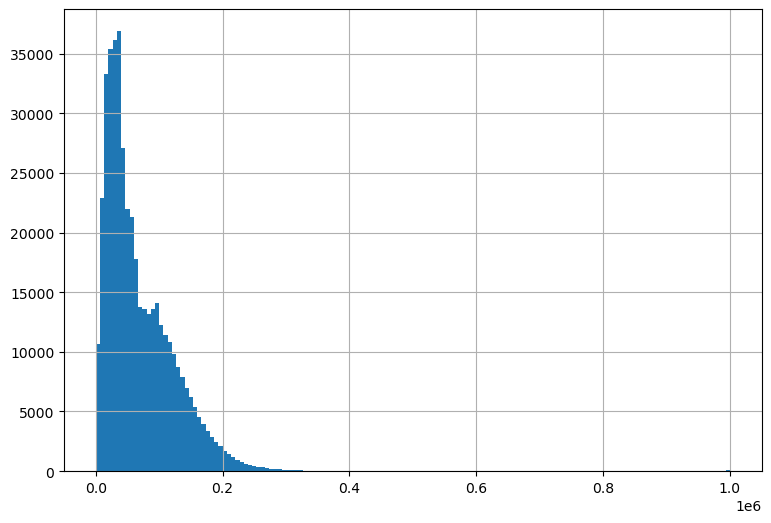

In [20]:
df['odometer'].hist(bins=150, figsize=(9,6))
df['odometer'].describe()

In [21]:
df['odometer'].quantile([.05, 0.95])

0.05     10475.0
0.95    170489.0
Name: odometer, dtype: float64

По пробегу мы видим что есть совершенно аномальные значения которые близки к 1 или максимальное значение в 999999. Так аномалии так же следует считать выбросами которые будут ухудшать работу модели предсказания.

Я построю функцию которая будет заменять выбросы и пустые значения пробега на медианные с учетом модели и года выпуска авто.

In [22]:
median_mileage_by_year_model = df.groupby(['year', 'model']).agg({'odometer': 'median'})

def replace_odometer_year_model(row): # функция для замены значений
    if (row['odometer'] == 1 and row['year'] != 2015 and row['year'] != 2014 and row['year'] != 2013) or (pd.isnull(row['odometer'])) or (row['odometer'] > 250000) or (row['odometer'] < 5000 and row['condition'] < 4 and row['year'] != 2015 and row['year'] != 2014 and row['year'] != 2013):
        median_value = median_mileage_by_year_model.loc[(row['year'], row['model']), 'odometer']
        return median_value
    else:
        return row['odometer']


df['odometer'] = df.apply(replace_odometer_year_model, axis=1) # заменяем значения пробега, удовлетворяющие условиям, на медианное значение

In [23]:
df.query('odometer>400000') # остался один явный выброс

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
24659,2002,NaN,750i,NaN,NaN,automatic,1fdxf46f42eb91925,ca,NaN,470368.0,red,—,autohaus,2600,2014-12-18 04:00:00+00:00
171948,1993,Ford,f-150,XL,Regular Cab,automatic,2ftdf15y0pcb40606,ms,1.0,528570.5,blue,blue,republic finance llc/pearl,200,2015-04-22 22:02:00+00:00
368362,1999,Mitsubishi,eclipse spyder,GS,Convertible,automatic,4a3ax35g5xe138358,fl,2.0,999999.0,silver,gray,coggin honda of st. augustine,650,2015-05-20 23:00:00+00:00


Я изменю ранее созданную функцию чтобы была такая же но без учета модели чтобы убрать оставшиеся выбросы

In [24]:
median_mileage_by_year = df.groupby(['year']).agg({'odometer': 'median'})

# Функция для замены значений
def replace_odometer_year(row):
    if (row['odometer'] == 1) or (pd.isnull(row['odometer'])) or (row['odometer'] > 550000) or (row['odometer'] < 400 and row['condition'] < 4 and row['year'] != 2015 and row['year'] != 2014 and row['year'] != 2013):
        median_value = median_mileage_by_year.loc[(row['year']), 'odometer']
        return median_value
    else:
        return row['odometer']


# Заменяем значения пробега, удовлетворяющие условиям, на медианное значение
df['odometer'] = df.apply(replace_odometer_year, axis=1)

In [25]:
df.query('odometer>400000') # проверка, выбросы устранены

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
24659,2002,NaN,750i,NaN,NaN,automatic,1fdxf46f42eb91925,ca,NaN,470368.0,red,—,autohaus,2600,2014-12-18 04:00:00+00:00
171948,1993,Ford,f-150,XL,Regular Cab,automatic,2ftdf15y0pcb40606,ms,1.0,528570.5,blue,blue,republic finance llc/pearl,200,2015-04-22 22:02:00+00:00


In [26]:
df.query('odometer==1 & year!= 2015 & year != 2014 & year != 2013') # явные выбросы замены на более релевантные значения

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate


In [27]:
df['odometer'].describe() # остались некие значения минимальные но они соотносятся с годом выпуска как новые авто и идеальным состоянием

count    440236.000000
mean      67866.007276
std       50524.722285
min           2.000000
25%       28457.000000
50%       52386.000000
75%       99568.000000
max      528570.500000
Name: odometer, dtype: float64

In [28]:
df['condition'].value_counts()

condition
1.9    33207
3.5    21016
3.7    20399
4.4    20027
4.3    19712
4.2    19345
3.6    18209
4.1    18108
2.0    16431
4.0    15797
3.9    15623
2.8    15012
2.9    14823
3.8    14785
3.4    13654
2.7    12837
4.9    10305
4.8    10040
2.5     9900
4.6     9897
4.5     9660
2.6     9403
4.7     9058
5.0     8862
3.3     8459
3.0     8451
3.2     7861
2.4     7378
2.1     7260
3.1     7258
2.3     6436
1.0     5855
2.2     4742
1.8      249
1.7      198
1.6      132
1.5      123
1.4      103
1.2       74
1.1       74
1.3       68
Name: count, dtype: int64

У нас есть около 9000 пропущенных значений на состоянии авто. Нужно заполнить пропуски. Состояние автомобиля более всего связано с пробегом. Но пробег у нас является количественной величиной. Я напишу функцию которая создаст дополнительный столбец с категорией по интервалу пробега

In [29]:
def create_category_column(df): # определяем границы категорий
    categories = pd.cut(df['odometer'], bins=100)


    df['odometer_category'] = categories # создаем новый столбец с категориями

    return df
create_category_column(df)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,odometer_category
0,2011,Ford,edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,2015-06-01 19:30:00+00:00,"(111001.385, 116287.07]"
1,2014,Ford,fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,2015-02-24 18:00:00+00:00,"(26430.425, 31716.11]"
2,2012,Nissan,sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,2015-06-09 19:30:00+00:00,"(31716.11, 37001.795]"
3,2003,HUMMER,h2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,2015-06-16 20:00:00+00:00,"(126858.44, 132144.125]"
4,2007,Ford,fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,2015-02-02 20:00:00+00:00,"(126858.44, 132144.125]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440231,2013,Kia,optima,EX Hybrid,Sedan,automatic,knagm4ad4d5057805,ca,4.5,20434.0,white,beige,"kia motors america, inc",16000,2015-01-19 20:30:00+00:00,"(15859.055, 21144.74]"
440232,2014,MINI,cooper countryman,S ALL4,Wagon,automatic,wmwzc5c55ewp36517,wi,2.9,14675.0,white,black,bmw mini financial services,24250,2015-02-10 18:00:00+00:00,"(10573.37, 15859.055]"
440233,2008,BMW,6 series,650i,Coupe,automatic,wbaea53588cv90110,ca,3.7,102552.0,gray,black,studio city auto group,16750,2015-03-02 20:30:00+00:00,"(100430.015, 105715.7]"
440234,2014,Ram,2500,SLT,Crew Cab,automatic,3c6ur5dl2eg243568,tx,3.0,29367.0,white,gray,express car & truck rental,33000,2015-01-13 18:05:00+00:00,"(26430.425, 31716.11]"


Теперь я создам похожую на то что я делал ранее фунцкию которя будет заменять пропуски медианным значеним. Будем группировать по году и интервалу пробега и в случае совпадения заполнить пропуски

In [30]:
median_condition_by_year_odometer = df.groupby(['year', 'odometer_category']).agg({'condition': 'median'})

def replace_condition_year_odometer(row): # функция для замены значений
    if pd.isnull(row['condition']):
        median_value = median_condition_by_year_odometer.loc[(row['year'], row['odometer_category']), 'condition']
        return median_value
    else:
        return row['condition']


df['condition'] = df.apply(replace_condition_year_odometer, axis=1) # заменяем значения condition, удовлетворяющие условиям, на медианное значение

In [31]:
df.query("condition.isna()") # еще осталось несколько значений

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,odometer_category
15389,1990,chevrolet,1500,4x2 ext base,NaN,NaN,2gcec19k2l1242286,mo,NaN,156215.0,white,—,animal protective association of missouri,800,2014-12-22 03:00:00+00:00,"(153286.865, 158572.55]"
24659,2002,NaN,750i,NaN,NaN,automatic,1fdxf46f42eb91925,ca,NaN,470368.0,red,—,autohaus,2600,2014-12-18 04:00:00+00:00,"(465142.28, 470427.965]"
70930,1992,Lexus,ls 400,Base,Sedan,NaN,jt8uf11e4n0136122,nj,NaN,92639.0,white,—,jns auto sales inc,1250,2014-12-17 01:30:00+00:00,"(89858.645, 95144.33]"
88777,1990,Chevrolet,corvette,Base,Hatchback,automatic,1g1yy2389l5108884,nv,NaN,80095.0,red,—,auto resource,3800,2014-12-18 03:45:00+00:00,"(79287.275, 84572.96]"
125907,1985,NaN,hhr,NaN,NaN,automatic,1g6el5787fe612281,il,NaN,67786.0,brown,—,phillips chevrolet of lansing inc,550,2014-12-18 02:00:00+00:00,"(63430.22, 68715.905]"
141426,1994,Ford,taurus,GL,Sedan,automatic,1falp52u4ra229476,ne,NaN,35649.0,burgundy,gray,woodhouse ford south inc,400,2014-12-18 03:00:00+00:00,"(31716.11, 37001.795]"
189769,1989,toyota,pickup,4x4 dx,NaN,manual,jt4rn01p2k0005711,ca,NaN,131187.0,white,gray,kearny mesa toyota,800,2014-12-17 04:00:00+00:00,"(126858.44, 132144.125]"
191451,2005,Toyota,prius,Base,Hatchback,automatic,jtdkb20u557026867,ne,NaN,4665.0,silver,gray,performance toyota-scion of lavista,3500,2014-12-18 03:00:00+00:00,"(-526.568, 5287.685]"
259231,1987,NaN,grand caravan,NaN,NaN,automatic,1fmeu15n6hla53716,fl,NaN,80081.0,black,—,nava motors corp,1500,2014-12-18 01:50:00+00:00,"(79287.275, 84572.96]"
272677,1993,Saturn,s-series,SL2,Sedan,NaN,1g8zk5575pz257319,ca,NaN,76047.0,NaN,NaN,apexcars net,300,2014-12-17 04:30:00+00:00,"(74001.59, 79287.275]"


Оставшиеся заменю просто группировкой по годам

In [32]:
median_condition_by_year = df.groupby('year')['condition'].median()
df['condition'] = df.apply(lambda row: median_condition_by_year[row['year']]
                        if pd.isna(row['condition']) else row['condition'], axis=1)

In [33]:
df.query("condition.isna()") # выбросы устранены

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,odometer_category


In [34]:
df['seller'].value_counts() # очень много уникальных значений

seller
nissan-infiniti lt                15823
ford motor credit company,llc     15276
the hertz corporation             14692
santander consumer                12230
avis corporation                  10098
                                  ...  
bay shore motors                      1
thrifty rent a car systems inc        1
volvo of wichita                      1
wright way hyundai                    1
studio city auto group                1
Name: count, Length: 13025, dtype: int64

In [35]:
df['seller'] = df['seller'].str.lower()
df['seller'] = df['seller'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
df["seller"].value_counts() # замня ненужных символов и приведение к нижнему реистру не помоли, будем работать как есть

seller
nissaninfiniti lt                    15823
ford motor credit companyllc         15276
the hertz corporation                14692
santander consumer                   12230
avis corporation                     10098
                                     ...  
united auto wholesale corporation        1
778025 alberta ltd                       1
alexander dodge chrysler jeep inc        1
pacific auto resellers                   1
studio city auto group                   1
Name: count, Length: 12995, dtype: int64

In [36]:
df.isna().sum()

year                     0
make                  8043
model                    0
trim                  8337
body                 10393
transmission         51461
vin                      0
state                    0
condition                0
odometer                 0
color                  586
interior               586
seller                   0
sellingprice             0
saledate                 0
odometer_category        0
dtype: int64

count    440236.000000
mean      13592.209588
std        9751.479098
min           1.000000
25%        6900.000000
50%       12100.000000
75%       18200.000000
max      230000.000000
Name: sellingprice, dtype: float64

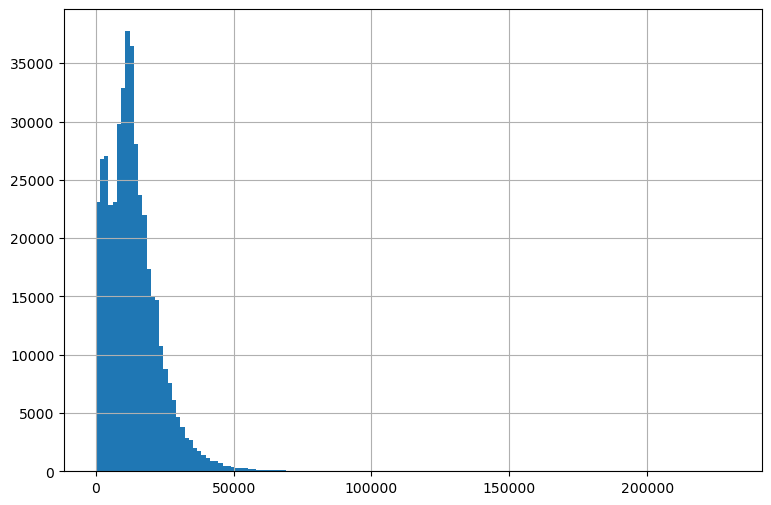

In [37]:
df['sellingprice'].hist(bins=150, figsize=(9,6))
df['sellingprice'].describe()

In [38]:
df['sellingprice'].quantile([.05, 0.95])

0.05     1500.0
0.95    30600.0
Name: sellingprice, dtype: float64

Мы видим явные выбросы на целевом признаке. Нам нужно внимательно с ним поработать чтобы модель могла научиться наиболее корректо предсказывать цену авто

In [39]:
df.query('sellingprice>200000') # не похоже на правду

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,odometer_category
392004,2014,Ford,escape,Titanium,SUV,automatic,1fmcu9j98eua23833,mo,4.3,27802.0,green,tan,fordlincoln dealer program,230000,2015-02-24 18:00:00+00:00,"(26430.425, 31716.11]"


In [40]:
df.query('model=="escape"')['sellingprice'].median() #это явный выброс, ошиблись с ноликом в конце

14900.0

Я составлю функцию которая по группировке по модели, году, пробегу будет менять значение выброса за рамками 5 и 95% на на медианное по группировке

In [41]:
def replace_outliers(group):
    sellingprice_median = group['sellingprice'].median()
    sellingprice_5_percent = sellingprice_median * 0.05
    sellingprice_95_quantile = group['sellingprice'].quantile(0.95)

    group.loc[group['sellingprice'] < sellingprice_5_percent, 'sellingprice'] = sellingprice_median
    group.loc[group['sellingprice'] > sellingprice_95_quantile, 'sellingprice'] = sellingprice_median

    return group

df = df.groupby(['model','year','odometer_category'],group_keys=False).apply(replace_outliers)

In [42]:
df['sellingprice'].describe() # неадекватные суммы в 100 долларов которые мы не сможем прогонзировать все равно остались

count    440236.000000
mean      13281.166127
std        9493.568376
min         100.000000
25%        6600.000000
50%       12000.000000
75%       17900.000000
max      183000.000000
Name: sellingprice, dtype: float64

In [43]:
df.query('sellingprice>200000') # не осталось самых неадекватных выбросов

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,odometer_category


In [44]:
df['transmission'].value_counts()

transmission
automatic    375061
manual        13714
Name: count, dtype: int64

Самое большое количество пропусков у нас содерджится в параметре Transmission. Для него и для остальные пропущенных значения я создам параметр "other" чтобы заполнить пропуски без удаления данных

In [45]:
df.isna().sum()

year                     0
make                  8043
model                    0
trim                  8337
body                 10393
transmission         51461
vin                      0
state                    0
condition                0
odometer                 0
color                  586
interior               586
seller                   0
sellingprice             0
saledate                 0
odometer_category        0
dtype: int64

In [46]:
df['make'] = df['make'].fillna('other')
df['trim'] = df['trim'].fillna('other')
df['body'] = df['body'].fillna('other')
df['transmission'] = df['transmission'].fillna('other')
df['color'] = df['color'].fillna('—')
df['interior'] = df['interior'].fillna('—')

In [47]:
print(df.info()) #итоговая проверка
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 440236 entries, 0 to 440235
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   year               440236 non-null  int64              
 1   make               440236 non-null  object             
 2   model              440236 non-null  object             
 3   trim               440236 non-null  object             
 4   body               440236 non-null  object             
 5   transmission       440236 non-null  object             
 6   vin                440236 non-null  object             
 7   state              440236 non-null  object             
 8   condition          440236 non-null  float64            
 9   odometer           440236 non-null  float64            
 10  color              440236 non-null  object             
 11  interior           440236 non-null  object             
 12  seller             440236 non-null 

year                 0
make                 0
model                0
trim                 0
body                 0
transmission         0
vin                  0
state                0
condition            0
odometer             0
color                0
interior             0
seller               0
sellingprice         0
saledate             0
odometer_category    0
dtype: int64

In [48]:
df.describe()

,year,condition,odometer,sellingprice
count,440236.000000,440236.000000,440236.000000,440236.000000
mean,2010.040101,3.410608,67866.007276,13281.166127
std,3.977945,0.949426,50524.722285,9493.568376
min,1982.000000,1.000000,2.000000,100.000000
25%,2007.000000,2.700000,28457.000000,6600.000000
50%,2012.000000,3.600000,52386.000000,12000.000000
75%,2013.000000,4.200000,99568.000000,17900.000000
max,2015.000000,5.000000,528570.500000,183000.000000


In [49]:
df[['year','model','state','interior','condition','odometer','sellingprice']].phik_matrix(interval_cols=['year', 'condition', 'odometer', 'sellingprice'])

,year,model,state,interior,condition,odometer,sellingprice
year,1.000000,0.742631,0.245191,0.274518,0.565637,0.722408,0.365136
model,0.742631,1.000000,0.542201,0.584924,0.435771,0.674399,0.901172
state,0.245191,0.542201,1.000000,0.222375,0.255334,0.263876,0.169270
interior,0.274518,0.584924,0.222375,1.000000,0.166941,0.224379,0.149573
condition,0.565637,0.435771,0.255334,0.166941,1.000000,0.549017,0.393559
odometer,0.722408,0.674399,0.263876,0.224379,0.549017,1.000000,0.406919
sellingprice,0.365136,0.901172,0.169270,0.149573,0.393559,0.406919,1.000000


Мы выбрали те признаки , которые в дальнейшем будем анализировать для оценки их коллениарности. Мы видим что целевой признак sellingprice наиболее зависим почти линейно от модели и марки автомобиля, что в целом очень соотносится со здравым смыслом. Наименее заметная связь с трансмиссией. В то же время колонки make и model имеют линейную зависимость между собой. Точно так же body и model имеют линейную зависимость. В целом такое соотношение может негативно сказываться на посторении модели для предсказания.
Далее для анализа попробуем использовать только параметр model, а make и body не будем пока использовать.

Так же мы наблюдаем высокую корреляцию seller с целевым признаком. color и transmission кореллируют очень слабо

Предобработка завершена. Приступим к обучению моделей.

# Обучение моделей

Построим несколько моделей для поиска лучшей. Затем проведем тестирование на тестовой выборке.

Выбрем признаки которые наиболее влияют на целевой признак и передадим в переменную df_clear

In [50]:
df_clear = df[['year','model','state','interior','condition','odometer','seller','sellingprice']].copy()

In [51]:
target = df_clear['sellingprice']
features = df_clear.drop(['sellingprice'], axis=1)

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

print(features_train.shape,features_test.shape)

(330177, 7) (110059, 7)


В каждой категории у нас очень много признаков. Используем ОЕ кодирование.

In [52]:
oe_features = features_train.select_dtypes(include='object').columns.to_list()
print(oe_features) # категориальные признаки для OE

num_features = features_train.select_dtypes(exclude='object').columns.to_list()
num_features # численные признакии

['model', 'state', 'interior', 'seller']


['year', 'condition', 'odometer']

## Построим модель для линейной регрессии

Используем трансформер чтобы создать новую переменную в которой будут сохранены преобразованные признаки катеориальные через ОЕ и числовые через StandardScaler

В коде мы будем использовать конструкцию GridSearchCV с использованием кросс-валидации

In [53]:
column_transformer = make_column_transformer(
    (StandardScaler(), num_features),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), oe_features),
    remainder='passthrough' 
)

linear_reg = make_pipeline(
    column_transformer,
    LinearRegression()
)

grid_space = {
}

grid_linear = GridSearchCV(linear_reg, scoring='neg_mean_absolute_percentage_error', param_grid=grid_space, cv=2, n_jobs=-1)

grid_linear.fit(features_train, target_train)
linear_reg_mape = -grid_linear.best_score_*100

print('Результат mape: ', linear_reg_mape)

Результат mape:  66.83650645799013


Отклонение для линейной регрессии составляет 66.8%, продолжим исследования.

## Построим модель случайного леса

Как и в модели выше мы будем использовать конвейер для последовательного преобразования признаков

In [54]:
column_transformer = make_column_transformer(
    (StandardScaler(), num_features),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), oe_features),
    remainder='passthrough' 
)
random_for = make_pipeline(
    column_transformer,
    RandomForestRegressor(random_state=12345)
)
grid_space = {
   'randomforestregressor__max_depth':[x for x in range(30,36,5)], 
   'randomforestregressor__n_estimators':[x for x in range(36,39,2)]
}

grid_forest = GridSearchCV(random_for, scoring='neg_mean_absolute_percentage_error', param_grid=grid_space, cv=2, n_jobs=-1)

grid_forest.fit(features_train, target_train)
rand_forest_mape = -grid_forest.best_score_*100

print('Лучшие гиперпараметры: ', grid_forest.best_params_)
print('Результат mape: ', rand_forest_mape)

Лучшие гиперпараметры:  {'randomforestregressor__max_depth': 35, 'randomforestregressor__n_estimators': 38}
Результат mape:  28.37783861333316


Отклонение для случайноо леса составляет 28.4%, продолжим исследования.

## Построим модель CatBoost

Посмотрим какие результаты покажет CatBoost с данными обработанными по ОЕ

In [55]:
%%time

column_transformer = make_column_transformer(
    (StandardScaler(), num_features),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), oe_features),
    remainder='passthrough' 
)
cat_model = make_pipeline(
    column_transformer,
    CatBoostRegressor(random_state=12345)
)
grid_space = {
    'catboostregressor__learning_rate':[0.1],
    'catboostregressor__verbose':[False],
    'catboostregressor__depth': [12],
    'catboostregressor__l2_leaf_reg': [1],
    'catboostregressor__iterations': [1400]
}

grid_oe = GridSearchCV(cat_model, scoring='neg_mean_absolute_percentage_error', param_grid=grid_space, cv=5, n_jobs=-1)

grid_oe.fit(features_train, target_train)
catboost_oe_mape = -grid_oe.best_score_*100

print('Лучшие гиперпараметры: ', grid_oe.best_params_)
print('Результат mape: : ', catboost_oe_mape)

Лучшие гиперпараметры:  {'catboostregressor__depth': 12, 'catboostregressor__iterations': 1400, 'catboostregressor__l2_leaf_reg': 1, 'catboostregressor__learning_rate': 0.1, 'catboostregressor__verbose': False}
Результат mape: :  20.95768420398294
CPU times: total: 18min 4s
Wall time: 9min 1s


Результат в 20.9% отклонения нас устраивает. Продолжим исследование

Попорбуем посмотреть результат CatBoost на выборку без преобразования признаков через ОЕ и Scaler

In [56]:
%%time

model = CatBoostRegressor(cat_features=['model','state','interior','seller'], random_state=12345)

grid_space={
            'learning_rate':[0.1],
            'verbose':[False],
            'depth': [12],
            'l2_leaf_reg': [1],
            'iterations': [1400]
}

grid = GridSearchCV(model, scoring='neg_mean_absolute_percentage_error', param_grid=grid_space , cv=5, n_jobs=-1)

grid.fit(features_train, target_train)

print('Лучшие гиперпараметры: ', grid.best_params_)
print('Результат mape: ', -grid.best_score_*100)

Лучшие гиперпараметры:  {'depth': 12, 'iterations': 1400, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'verbose': False}
Результат mape:  18.60458821579604
CPU times: total: 57min 50s
Wall time: 20min 49s


In [57]:
best_model = grid.best_estimator_ # получение наилучшей модели

best_model.feature_importances_ # получение важности признаков

array([16.40055777, 33.63548774,  6.66686142,  5.76647472,  6.75654055,
       20.22754632, 10.54653148])

In [58]:
importances = np.array([16.40055777, 33.63548774,  6.66686142,  5.76647472,  6.75654055, 20.22754632, 10.54653148])
feature_names = np.array(['year','model','state','interior','condition','odometer','seller'])

feature_importances = dict(zip(feature_names, importances)) # создание словаря с названиями признаков и их значениями важности

feature_importances

{'year': 16.40055777,
 'model': 33.63548774,
 'state': 6.66686142,
 'interior': 5.76647472,
 'condition': 6.75654055,
 'odometer': 20.22754632,
 'seller': 10.54653148}

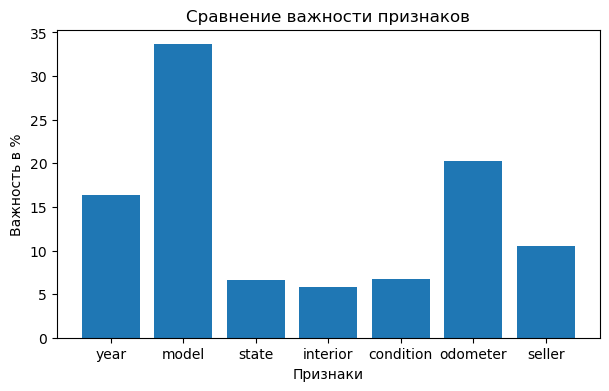

In [59]:
plt.figure(figsize=(7,4))
plt.bar(feature_names, importances)
plt.xlabel('Признаки')
plt.ylabel('Важность в %')
plt.title('Сравнение важности признаков')
plt.show()

Мы получили лучший результат в 18.6% отклонения на данных которые работают без ОЕ, они существенно медленнее, но точнее

Самый важный признак который оценила модель для принятия решения о цене оказался модель машины с резульатом 33.6%, 20.2% показатель пробега. Я думаю что такие данные совпадают с ожиаднием реальности.

Промежуточный вовод: мы построили несколько моделей для предсказания MAPe

Линеймная модель показала результат 66.8% отклонение

Случайны лес показал 28.4%

CatBost OE показал 20.9%

CatBost без трансформера 18.6%

## Тестирование

Проведем тестирование модели на нашей лучшей модели

In [60]:
predictions_CatBoost = grid.predict(features_test)

mean_absolute_percentage_error(target_test,predictions_CatBoost)*100

18.32771893912138

На тестовой модели мы получили результат 18.3%, нас этот результат устраивает.

## Dummy модель

In [61]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
DummyRegressor()
dummy_regr_predict = dummy_regr.predict(features_test)
mape = mean_absolute_percentage_error(target_test,dummy_regr_predict)
mape = mape*100
print('Среднее отклонение в процентах для модели Дамми составляет:', mape)

Среднее отклонение в процентах для модели Дамми составляет: 185.87524258956037


Таким образом наша модель в несколько раз лучше стандартной Дамми модели, а значит она проходит тест на адекватность.

## Общий вывод:

В нашем распоряжении файл с данными об аукционах автомобилей США и Канады. Перед нами стояла задача построить модель котора будет предсказывать цену авто.

В качестве метрики качества мы использовали MAPE

В ходе работы мы прошли основные этапы исследования:
-    загрузка и ознакомление с данными,
-    предварительная обработка,
-    полноценный разведочный анализ,
-    разработка новых синтетических признаков,
-    проверка на мультиколлинеарность,
-    отбор финального набора обучающих признаков,
-    выбор и обучение моделей,
-    итоговая оценка качества предсказания лучшей модели,
-    анализ важности ее признаков.

В ходе предобработки данных мы выявили выбросы и устранили их с помощью замены медианными признаками по коррелирующим признакам. Так же у нас была несколько признаков коррелирующих между собой со значеним 1. Это бы повредило качесву предсказания поэтому мы выбрали model а make и trim не использовали.

У нас был недостаток значений в важнейшем поле model, но зато были все vin номера. Поэтому мы подгрузили недостающую информацию из открытых источников по API.

Далее мы приступили к тестированию моделей обучения. В связи с тем что у нас больше количество признаков например в поле seller более 12000, мы приняли решение использовать ОЕ. Мы создали новые признаки с помощью трасформера с использованием ОЕ для категориальных признаков и StandartScaler для числовых признаков с использованием кросс-валидации.
Мы получили следующие резульататы MAPE:
 - Линеймная модель показала результат 66.8% отклонение
 - Случайны лес показал 28.4%
 - CatBost OE показал 20.9%
 - CatBost без трансформера 18.6%

Важность признаков лучшей модели говорит о том что модель и пробег авто наиболее влияют на цену продажи.

Мы получили лучшую модель на тренировочной выборке и приступили к тестированию.

На тестовой выборке наша лучшая модель CatBost без трансформера показала результат 18.3%, в то время как Дамми модель показала результат 186%. Таким образом мы видим, что наша модель сильно лучше простой модели Даммии и это говорит о полезности нашей работы.